In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

import time
# Author: Gourang Gaurav
%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)

Preprocessing:

In [3]:
def get_one_hot_encoding(X_train, X_test):
    x_train_no_recs = len(X_train.index)
    
    X_temp = pd.concat([X_train, X_test])
    X_temp = pd.get_dummies(X_temp)
    
    X_train = X_temp.iloc[:x_train_no_recs,:]
    X_test = X_temp.iloc[x_train_no_recs:,:]
    
    return X_train, X_test

In [4]:
def woe_iv_categor(X, y):
    df1 = pd.DataFrame({'X':X, 'y':y})
    df1_grp = df1.groupby('X')
    tot_event_cnt = df1['y'].sum()
    grp_len = df1_grp['y'].count()
    grp_sum = df1_grp['y'].sum()
    df2= pd.DataFrame()
    df2['Event_prcnt'] = grp_sum/ grp_len
    df2['Non_Event_prcnt'] = (grp_len - grp_sum) / grp_len
    df2['Event_prcnt_sum'] = grp_sum/ tot_event_cnt 
    df2['Non_Event_prcnt_sum'] = (grp_len - grp_sum)/ (len(df1.index) - tot_event_cnt)
    df2['event_div_nonevent'] = df2['Event_prcnt_sum']/ df2['Non_Event_prcnt_sum']
    idx_greater_zero = df2['event_div_nonevent']>0
    df2['WoE'] = 0.0
    df2.loc[idx_greater_zero, 'WoE'] = np.log(df2.loc[idx_greater_zero, 'event_div_nonevent'])
    df2['IV'] = (df2['Event_prcnt_sum']-df2['Non_Event_prcnt_sum']) * df2['WoE']
    df2.replace([np.inf, -np.inf], 0, inplace=True)
    return df2['WoE'], df2['IV'].sum()

In [5]:
def drop_train_cols(x):
    x.dropna(axis=1, how='all', inplace=True)
    nuniques = x.nunique()  # columns with 1 unique value had very few NA values; so removed here the nunique arg dropna=False
    x.drop(columns=nuniques[nuniques==1].index, inplace=True)
    x.drop(columns=['id', 'member_id', 'url', 'emp_title', 'next_pymnt_d',
                    'last_pymnt_d', 'last_credit_pull_d', 'issue_d',
                    'earliest_cr_line', 'desc', 'title'], inplace=True)
    return x

In [6]:
def preprocess(x, train_flag, train_stats=None):
    # 90% 'mths_since_last_record' values are missing, so, making it binary to show if the cust has any public record  
    x['mths_since_last_record'] = x['mths_since_last_record'].apply(lambda x: 0
                                                                    if np.isnan(x)
                                                                    else 1)
    x['mths_since_last_delinq'].fillna(1000, inplace=True)  # filling with 1000 to show that there was no delinquence
    x['int_rate'] = x['int_rate'].str[:-1].astype(float)
    x['revol_util'] = x['revol_util'].str[:-1].astype(float)
    
    if train_flag:
        train_stats = dict()
        train_stats['emp_len_most_freq'] = x['emp_length'].value_counts(dropna=False).index[0]
        rare_purpose_vals = x['purpose'].value_counts()
        train_stats['rare_prupose_vals'] = rare_purpose_vals[rare_purpose_vals <= 225].index
        rare_addr_state = x['addr_state'].value_counts()
        train_stats['rare_addr_state'] = rare_addr_state[rare_addr_state <= 31].index
        rare_zip_codes = x['zip_code'].value_counts(normalize=True)
        train_stats['rare_zip_codes'] = rare_zip_codes[rare_zip_codes < 0.00005].index
        train_stats['pub_rec_bank_med'] = x['pub_rec_bankruptcies'].median()
        train_stats['revol_util_med'] = x['revol_util'].median()
    
    # grouping rare values (being in less than 5% of training examples) as 1 category rare
    x.loc[x['addr_state'].isin(train_stats['rare_addr_state']), 'addr_state'] = 'rare_state'
    x.loc[x['purpose'].isin(train_stats['rare_prupose_vals']), 'purpose'] = 'rare_purpose' #  less than 1% of the data and similar class percentage
    x.loc[x['zip_code'].isin(train_stats['rare_zip_codes']), 'zip_code'] = 'rare_zip_code'
    
    x['pub_rec_bankruptcies'].fillna(train_stats['pub_rec_bank_med'], inplace=True)
    x['revol_util'].fillna(train_stats['revol_util_med'], inplace=True)
    
    # making emp_length as an orinal column as there is a clear order in it
    x['emp_length'].fillna(train_stats['emp_len_most_freq'], inplace=True)
    emp_length_cat = pd.Categorical(x['emp_length'], 
                                    categories=['< 1 year', '1 year', '2 years',
                                                '3 years', '4 years', '5 years',
                                                '6 years', '7 years', '8 years',
                                                '9 years', '10+ years'], 
                                    ordered=True)
    emp_length_cat, _ = pd.factorize(emp_length_cat, sort=True)
    x['emp_length'] = emp_length_cat
    
    x['term'].replace({' 36 months': 36, ' 60 months': 60},  inplace=True)
    
    # subgrades of E, F and G affected lot of fluctuations in the % of target belonging to their group
    # So, including them in the grade column itself and then dropping subgrde
    x['grade'] = np.where(x['grade'].isin(['E', 'F', 'G']),
                          x['sub_grade'], x['grade'])
    x.drop(columns='sub_grade', inplace=True)   
    
    return x, train_stats
    

In [7]:
train_df = pd.read_csv('loan_train.csv')
test_df = pd.read_csv('loan_test.csv')

# doing preprocessing with all the training examples including 'Current' loan status records for more correct mean/ median

train_df = drop_train_cols(train_df)
test_df = test_df[train_df.columns]

train_df, train_stats = preprocess(train_df, train_flag=True)
test_df, _ = preprocess(test_df, train_flag=False, train_stats=train_stats)

# removing records with 'Current' laon status as that would not be required in the model
train_df = train_df[train_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
y_train = train_df['loan_status'].apply(lambda x: 1 if x=='Fully Paid' else 0)
train_df.drop(columns='loan_status', inplace=True)
# # +ve, fully paid samples 0.8570429200444426

test_df = test_df[test_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
y_test = test_df['loan_status'].apply(lambda x: 1 if x=='Fully Paid' else 0)
test_df.drop(columns='loan_status', inplace=True)

# getting the zipcodes and state in test data which are not present in the training set
train_set_zipcode = set(train_df['zip_code'].unique()) 
test_set_zipcode = set(test_df['zip_code'].unique())
zipcode_not_in_train = test_set_zipcode - train_set_zipcode
test_df.loc[test_df['zip_code'].isin(zipcode_not_in_train), 'zip_code'] = 'rare_zip_code'

train_set_state = set(train_df['addr_state'].unique()) 
test_set_state = set(test_df['addr_state'].unique())
state_not_in_train = test_set_state - train_set_state
test_df.loc[test_df['addr_state'].isin(state_not_in_train), 'addr_state'] = 'rare_state'

# as zipcode and state are high dimensional categorical fields, using weight of evidence values
# to convert into meaningful numbers with increasing the dimension of the data
woe_zip, inf_val_zip = woe_iv_categor(train_df['zip_code'], y_train)
if inf_val_zip>=0.02 and inf_val_zip <=0.5: # col has good predictive value
    train_df['zip_code'].replace(woe_zip.index, woe_zip.values, inplace=True)
    test_df['zip_code'].replace(woe_zip.index, woe_zip.values, inplace=True)

woe_state, inf_val_state = woe_iv_categor(train_df['addr_state'], y_train)
if inf_val_state>=0.02 and inf_val_state <=0.5: # col has good predictive value
    train_df['addr_state'].replace(woe_state.index, woe_state.values, inplace=True)
    test_df['addr_state'].replace(woe_state.index, woe_state.values, inplace=True)

train_df, test_df = get_one_hot_encoding(train_df, test_df)

In [8]:
train_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,grade_A,grade_B,grade_C,grade_D,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F1,grade_F2,grade_F3,grade_F4,grade_F5,grade_G1,grade_G2,grade_G3,grade_G4,grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_rare_purpose,purpose_small_business,purpose_vacation,purpose_wedding
0,10000,10000,9950.0,36,7.51,311.11,10,30000.0,-0.125936,-0.153769,5.00,0,3,1000.0,0,19,0,1450,1.2,48,0.0,0.0,2247.210000,2235.98,1509.91,350.87,0.0,386.43,3.96,311.11,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,15000,15000,14800.0,36,8.94,476.58,1,147000.0,0.183137,-0.037545,3.47,0,0,1000.0,0,6,0,4910,14.0,17,0.0,0.0,15112.760000,14911.26,15000.00,112.76,0.0,0.00,0.00,15114.03,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2000,2000,2000.0,36,13.57,67.94,4,36000.0,-0.404649,-0.037545,7.83,0,0,1000.0,0,8,0,1790,34.4,10,0.0,0.0,2354.966827,2354.97,2000.00,354.97,0.0,0.00,0.00,101.78,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,14000,14000,14000.0,60,17.49,351.64,5,50000.0,-0.220726,-0.266834,21.24,1,1,21.0,1,9,1,553,9.4,27,0.0,0.0,20804.230020,20804.23,14000.00,6804.23,0.0,0.00,0.00,3943.27,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,12000,12000,11900.0,36,8.94,381.26,7,294000.0,-0.086195,-0.125975,0.50,0,0,1000.0,0,11,0,5306,2.8,21,0.0,0.0,12344.811770,12241.94,12000.00,344.81,0.0,0.00,0.00,11204.30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Grid Search to get the hyperparameters for the sklearn Gradient Boosting Classifier:

In [9]:
# Starting with 100 estimators, searching for tree parmaters with most impact,
# firstly min_samples_split and max_depth
params_estimators = {'min_samples_split':np.linspace(200,1000,5,dtype=int), 'max_depth':range(5,16,2)}
gs_max_depth_min_samp_split = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.2, min_samples_leaf=50,
    max_features='sqrt',subsample=0.8,random_state=0
), 
param_grid = params_estimators, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gs_max_depth_min_samp_split.fit(train_df, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  preso

In [11]:
gs_max_depth_min_samp_split.best_params_, gs_max_depth_min_samp_split.best_score_

({'max_depth': 9, 'min_samples_split': 1000}, 0.9960906788423038)

In [16]:
np.mean(gs_max_depth_min_samp_split.predict(test_df)==y_test)

0.9960072849537686

In [17]:
# As min_samples_split reached the highest values in the above search, continuing search for higher values along with 
# search for min_samples_leaf
params_estimators = {'min_samples_split':np.linspace(1000,2000,5,dtype=int),
                     'min_samples_leaf':range(40,81,10)}
gs_min_samp_split_samples_leaf = GridSearchCV(
    estimator = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.2, max_depth=9,
        max_features='sqrt',subsample=0.8,random_state=0
), 
param_grid = params_estimators, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gs_min_samp_split_samples_leaf.fit(train_df, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=9,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presor

In [18]:
gs_min_samp_split_samples_leaf.best_params_, gs_min_samp_split_samples_leaf.best_score_

({'min_samples_leaf': 50, 'min_samples_split': 1750}, 0.996214084827162)

In [19]:
np.mean(gs_min_samp_split_samples_leaf.predict(test_df)==y_test)

0.9958671896889885

In [20]:
# With the above values obtained, now searching for max_features for the tree
params_estimators = {'max_features': np.linspace(8, 70, 20, dtype=int)}
gs_max_features = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.2,min_samples_split=1750,min_samples_leaf=50,max_depth=9,
    subsample=0.8,random_state=0
), 
param_grid = params_estimators, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gs_max_features.fit(train_df, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=9,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=1750,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pres

In [21]:
gs_max_features.best_params_, gs_max_features.best_score_

({'max_features': 56}, 0.9971194177072196)

In [22]:
np.mean(gs_max_features.predict(test_df)==y_test)

0.9968478565424489

In [23]:
list(zip(gs_max_features.cv_results_['params'], gs_max_features.cv_results_['mean_test_score']))

[({'max_features': 8}, 0.996214084827162),
 ({'max_features': 11}, 0.996255270964198),
 ({'max_features': 14}, 0.9962141187008235),
 ({'max_features': 17}, 0.9966256667528818),
 ({'max_features': 21}, 0.9966256413450221),
 ({'max_features': 24}, 0.9967902419327179),
 ({'max_features': 27}, 0.9969548255888101),
 ({'max_features': 30}, 0.9969960117223617),
 ({'max_features': 34}, 0.9969548171195235),
 ({'max_features': 37}, 0.997078299314022),
 ({'max_features': 40}, 0.9969548255853254),
 ({'max_features': 43}, 0.996913673321951),
 ({'max_features': 47}, 0.9969548425204142),
 ({'max_features': 50}, 0.9969959863249557),
 ({'max_features': 53}, 0.9970782739166163),
 ({'max_features': 56}, 0.9971194177072196),
 ({'max_features': 60}, 0.9970371385848456),
 ({'max_features': 63}, 0.9970371301120744),
 ({'max_features': 66}, 0.9969136902605242),
 ({'max_features': 70}, 0.997037121649757)]

In [24]:
# max_features 37 and 56 give best results, taking 37 and now searching for subsample parameter
params_estimators = {'subsample':[0.7,0.75,0.8,0.85,0.9, 1.0]}
gs_subsample = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.2,min_samples_split=1750,min_samples_leaf=50,max_depth=9,
    max_features=37,random_state=0
), 
param_grid = params_estimators, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gs_subsample.fit(train_df, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=9,
                                                  max_features=37,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=1750,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presor

In [25]:
np.mean(gs_subsample.predict(test_df)==y_test)

0.997408237601569

In [26]:
gs_subsample.best_params_, gs_subsample.best_score_

({'subsample': 1.0}, 0.9974897965573302)

In [27]:
list(zip(gs_subsample.cv_results_['params'], gs_subsample.cv_results_['mean_test_score']))

[({'subsample': 0.7}, 0.9969960032530751),
 ({'subsample': 0.75}, 0.9968725295313478),
 ({'subsample': 0.8}, 0.997078299314022),
 ({'subsample': 0.85}, 0.9969136648561492),
 ({'subsample': 0.9}, 0.9972017645769167),
 ({'subsample': 1.0}, 0.9974897965573302)]

In [28]:
# Now we have all the parameter except the n_estimators which we can increase and see if the accuracy increases 
start_time = time.time()
gbm = GradientBoostingClassifier(
    n_estimators=500, learning_rate=0.1, min_samples_split=1750,min_samples_leaf=50,max_depth=9,
    max_features=37,subsample=1,random_state=0
)
gbm.fit(train_df, y_train)
print("gbm training time: {0}".format(time.time()-start_time))

gbm training time: 54.44065475463867


In [29]:
np.mean(y_test==gbm.predict(test_df))

0.9975483328663491

In [30]:
start_time = time.time()
gbm = GradientBoostingClassifier(
    n_estimators=1000, learning_rate=0.05, min_samples_split=1750,min_samples_leaf=50,max_depth=9,
    max_features=37,subsample=1,random_state=0
)
gbm.fit(train_df, y_train)
print("gbm training time: {0}".format(time.time()-start_time))

gbm training time: 102.4101140499115


In [32]:
np.mean(y_test==gbm.predict(test_df))

0.9976884281311291

In [34]:
# Checking randomly if some parmeter changes improve the accuracy
start_time = time.time()
gbm = GradientBoostingClassifier(
    n_estimators=1000, learning_rate=0.3, min_samples_split=200,min_samples_leaf=50,max_depth=5,
    max_features='auto',subsample=1,random_state=0
)
gbm.fit(train_df, y_train)
print("gbm training time: {0}".format(time.time()-start_time))

gbm training time: 28.668821573257446


In [35]:
# The highest accuracy obtained with the parameters in the above cell
np.mean(y_test==gbm.predict(test_df))

0.9979686186606893

Feature Importance:

In [36]:
predictors = train_df.columns
feat_imp = pd.Series(gbm.feature_importances_, predictors).sort_values(ascending=False)

<BarContainer object of 15 artists>

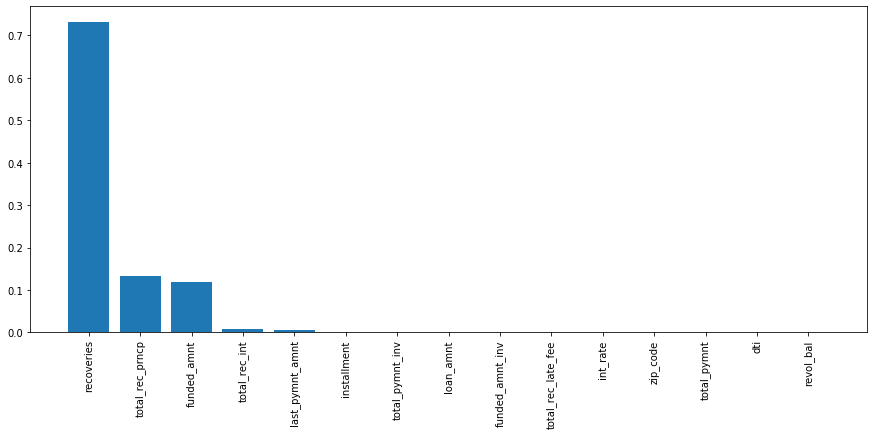

In [40]:
plt.figure(figsize=(15,6))
plt.xticks(rotation="vertical")
plt.bar(feat_imp.index[:15], feat_imp.values[:15])

<BarContainer object of 20 artists>

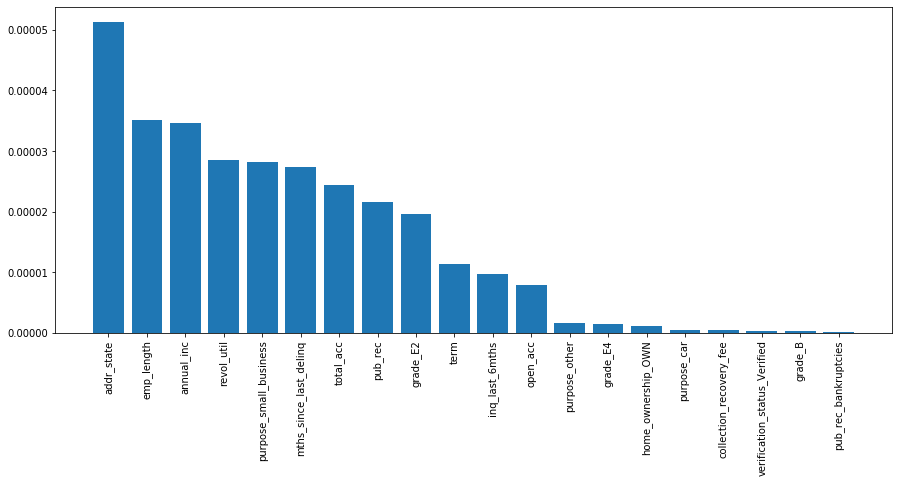

In [41]:
plt.figure(figsize=(15,6))
plt.xticks(rotation="vertical")
plt.bar(feat_imp.index[15:35], feat_imp.values[15:35])

In [ ]:
# temp = pd.DataFrame(train_df['purpose'].value_counts())
# temp['class_percent'] = train_df_non_cur.groupby('purpose')['loan_status'].apply(np.mean)
# temp.sort_values(by='class_percent')
# temp

In [ ]:
# sub_grade_mean = train_df_non_cur.groupby('sub_grade')['loan_status'].apply(np.mean)
# plt.plot(range(len(sub_grade_mean)), sub_grade_mean)

In [ ]:
# grade_mean = train_df_non_cur.groupby('grade')['loan_status'].apply(np.mean)
# # plt.plot(range(len(grade_mean)), grade_mean)
# grade_mean

In [ ]:
# mths_delinq = train_df_non_cur.groupby('mths_since_last_delinq')['loan_status'].apply(np.mean)
# mths_delinq_idx = mths_delinq.index
# mths_delinq_vals = mths_delinq.values
# plt.plot(mths_delinq_idx, mths_delinq_vals)

In [ ]:
# train_df_non_cur.loc[train_df_non_cur['mths_since_last_delinq'].isna(), 'loan_status'].mean()

In [ ]:
# temp = pd.DataFrame(train_df['mths_since_last_delinq'])
# temp = temp.groupby('mths_since_last_delinq')['mths_since_last_delinq'].apply(lambda x: x.count())
# # print(temp.index)
# temp.values.sum()